<font size="+3"><strong>6.4. Interactive Dashboard</strong></font>

In the last lesson, we built a model based on the highest-variance features in our dataset and created several visualizations to communicate our results. In this lesson, we're going to combine all of these elements into a dynamic web application that will allow users to choose their own features, build a model, and evaluate its performance through a graphic user interface. In other words, you'll create a tool that will allow anyone to build a model without code. 

<div class="alert alert-block alert-warning">
<p><b>Warning:</b> If you have issues with your app launching during this project, try restarting your kernel and re-running the notebook from the beginning. Go to <b>Kernel</b> > <b>Restart Kernel and Clear All Outputs</b>.</p>
<p>If that doesn't work, close the browser window for your virtual machine, and then relaunch it from the "Overview" section of the WQU learning platform.</p> 
</div>

In [80]:
import pandas as pd
import os
import plotly.express as px
from dash import Input, Output, dcc, html
from IPython.display import VimeoVideo
from dash import Dash
from scipy.stats.mstats import trimmed_var
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


> Note : We are using Dash instead of JupyterDash because it is deprecated.

In [81]:
VimeoVideo("715724401", h="062cb7d8cb", width=600)

# Prepare Data

As always, we'll start by bringing our data into the project using a `wrangle` function.

## Import

In [82]:
VimeoVideo("715724313", h="711e785135", width=600)

**Task 6.4.1:** Complete the `wrangle` function below, using the docstring as a guide. Then use your function to read the file `"data/SCFP2019.csv.gz"` into a DataFrame. 

In [83]:
def wrangle(filepath):  
    """Read SCF data file into ``DataFrame``.

    Returns only credit fearful households whose net worth is less than $2 million.

    Parameters
    ----------
    filepath : str
        Location of CSV file.
    """
    
    df=pd.read_csv(filepath)
    mask=(df["TURNFEAR"]==1) & (df["NETWORTH"]<2e6)
    df=df[mask]
    return df
    
   

In [84]:
df =wrangle("data/SCFP2019.csv.gz")

print("df type:", type(df))
print("df shape:", df.shape)
df.head()

df type: <class 'pandas.core.frame.DataFrame'>
df shape: (4418, 351)


,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
5,2,21,3790.476607,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2
6,2,22,3798.868505,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,3,2,2
7,2,23,3799.468393,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2
8,2,24,3788.076005,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2
9,2,25,3793.066589,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2


# Build Dashboard

It's app time! There are lots of steps to follow here, but, by the end, you'll have made an interactive dashboard! We'll start with the layout.

## Application Layout

First, instantiate the application.

In [85]:
VimeoVideo("715724244", h="41e32f352f", width=600)

**Task 6.4.2:** Instantiate a `Dash` application and assign it to the variable name `app`.

> Remember to use `Dash` instead of `JupyterDash` 

In [86]:
app = Dash(__name__)

print("app type:", type(app))

app type: <class 'dash.dash.Dash'>


Then, let's give the app some labels.

In [87]:
VimeoVideo("715724173", h="21f2757631", width=600)

**Task 6.4.3:** Start building the layout of your `app` by creating a `Div` object that has two child objects: an `H1` header that reads `"Survey of Consumer Finances"` and an `H2` header that reads `"High Variance Features"`.

<div class="alert alert-block alert-info">
<b>Note:</b> We're going to build the layout for our application iteratively. So be prepared to return to this block of code several times as we add features.
</div>

In [88]:
app.layout = html.Div(
    [
        html.H1("Survey of Consumer Finances"),
        html.H2("High Variance Features"),
        dcc.Graph(id="bar-chart"),
        dcc.RadioItems(
            options=[
                {
                    "label":"trimmed","value":True
                },
                {"label":"not trimmed","value":False}
                
            ],value=True,id="trim-button"
        ),
        html.H2("K-means Clustering"),
        html.H3( "Number of Clusters (k)"),
        dcc.Slider(min=2,max=12,step=1,value=2,id="k-slider"),
        html.Div(id="matrix"),

        dcc.Graph(id="pca-scatter")
    ]
)

Eventually, the app we make will have several interactive parts. We'll start with a bar chart.

## Variance Bar Chart

No matter how well-designed the chart might be, it won't show up in the app unless we add it to the dashboard as an object first.

In [89]:
VimeoVideo("715724086", h="e9ed963958", width=600)

**Task 6.4.4:** Add a `Graph` object to your application's layout. Be sure to give it the id `"bar-chart"`.

Just like we did last time, we need to retrieve the features with the highest variance.

In [90]:
VimeoVideo("715724816", h="80ec24d3d6", width=600)

**Task 6.4.5:** Create a `get_high_var_features` function that returns the five highest-variance features in a DataFrame. Use the docstring for guidance. 

In [91]:
def get_high_var_features(trimmed=True,return_feat_names=True): 
    """Returns the five highest-variance features of ``df``.

    Parameters
    ----------
    trimmed : bool, default=True
        If ``True``, calculates trimmed variance, removing bottom and top 10%
        of observations.

    return_feat_names : bool, default=False
        If ``True``, returns feature names as a ``list``. If ``False``
        returns ``Series``, where index is feature names and values are
        variances.
    """
    if trimmed:
        top_five_features=(
            df.apply(trimmed_var).sort_values().tail(5)
        )
    else:
        top_five_features=df.var().sort_values().tail(5)
    if return_feat_names:  
        top_five_features=top_five_features.index.to_list()
    return top_five_features

Now that we have our top five features, we can use a function to return them in a bar chart.

In [92]:
VimeoVideo("715724735", h="5238a5c518", width=600)

**Task 6.4.6:** Create a `serve_bar_chart` function that returns a plotly express bar chart of the five highest-variance features. You should use `get_high_var_features` as a helper function. Follow the docstring for guidance.

In [93]:
@app.callback(
    Output("bar-chart","figure"),Input("trim-button","value")
)
def serve_bar_chart(trimmed=True): 
    """Returns a horizontal bar chart of five highest-variance features.

    Parameters
    ----------
    trimmed : bool, default=True
        If ``True``, calculates trimmed variance, removing bottom and top 10%
        of observations.
    """
    top_five_features=get_high_var_features(trimmed=trimmed,return_feat_names=False)
    fig=px.bar(x=top_five_features,y=top_five_features.index,orientation="h")
    fig.update_layout(xaxis_title="Variance",yaxis_title="Features")
    return fig

Now, add the actual chart to the app.

In [94]:
VimeoVideo("715724706", h="b672dd9202", width=600)

**Task 6.4.7:** Use your `serve_bar_chart` function to add a bar chart to `"bar-chart"`. <span style='color: transparent; font-size:1%'>WQU WorldQuant University Applied Data Science Lab QQQQ</span>

What we've done so far hasn't been all that different from other visualizations we've built in the past. Most of those charts have been static, but this one's going to be interactive. Let's add a radio button to give people something to play with.

In [95]:
VimeoVideo("715724662", h="957a128506", width=600)

**Task 6.4.8:** Add a radio button to your application's layout. It should have two options: `"trimmed"` (which carries the value `True`) and `"not trimmed"` (which carries the value `False`). Be sure to give it the id `"trim-button"`.

Now that we have code to create our bar chart, a place in our app to put it, and a button to manipulate it, let's connect all three elements.

In [96]:
VimeoVideo("715724573", h="7de7932f70", width=600)

**Task 6.4.9:** Add a callback decorator to your `serve_bar_chart` function. The callback input should be the value returned by `"trim-button"`, and the output should be directed to `"bar-chart"`.

When you're satisfied with your bar chart and radio buttons, scroll down to the bottom of this page and run the last block of code to see your work in action!

## K-means Slider and Metrics

Okay, so now our app has a radio button, but that's only one thing for a viewer to interact with. Buttons are fun, but what if we made a slider to help people see what it means for the number of clusters to change. Let's do it!

Again, start by adding some objects to the layout.

In [97]:
VimeoVideo("715725482", h="88aa75b1e2", width=600)

**Task 6.4.10:** Add two text objects to your application's layout: an `H2` header that reads `"K-means Clustering"` and an `H3` header that reads `"Number of Clusters (k)"`. 

Now add the slider.

In [98]:
VimeoVideo("715725430", h="5d24607b0c", width=600)

**Task 6.4.11:** Add a slider to your application's layout. It should range from `2` to `12`. Be sure to give it the id `"k-slider"`.

And add the whole thing to the app.

In [99]:
VimeoVideo("715725405", h="8944b9c674", width=600)

**Task 6.4.12:** Add a `Div` object to your applications layout. Be sure to give it the id `"metrics"`.

So now we have a bar chart that changes with a radio button, and a slider that changes... well, nothing yet. Let's give it a model to work with.

In [100]:
VimeoVideo("715725235", h="55229ebf88", width=600)

**Task 6.4.13:** Create a `get_model_metrics` function that builds, trains, and evaluates `KMeans` model. Use the docstring for guidance. Note that, like the model you made in the last lesson, your model here should be a pipeline that includes a `StandardScaler`. Once you're done, submit your function to the grader.

In [101]:
def get_model_metrics(trimmed=True,k=2,return_metrics=False):  
    """Build ``KMeans`` model based on five highest-variance features in ``df``.

    Parameters
    ----------
    trimmed : bool, default=True
        If ``True``, calculates trimmed variance, removing bottom and top 10%
        of observations.

    k : int, default=2
        Number of clusters.

    return_metrics : bool, default=False
        If ``False`` returns ``KMeans`` model. If ``True`` returns ``dict``
        with inertia and silhouette score.

    """
    features=get_high_var_features(trimmed=trimmed,return_feat_names=True)
    X=df[features]
    model=make_pipeline(
        StandardScaler(),
        KMeans(n_clusters=k,random_state=42)
    )
    model.fit(X)
    if return_metrics:
        i=model.named_steps["kmeans"].inertia_
        ss=silhouette_score(X,model.named_steps["kmeans"].labels_)
        metrics={
            "inertia":round(i),
            "silhouette":round(ss,3)
            
        }
        return metrics
    return model

Part of what we want people to be able to do with the dashboard is see how the model's inertia and silhouette score when they move the slider around, so let's calculate those numbers...

In [102]:
VimeoVideo("715725137", h="124312b155", width=600)

**Task 6.4.14:** Create a `serve_metrics` function. It should use your `get_model_metrics` to build and get the metrics for a model, and then return two objects: An `H3` header with the model's inertia and another `H3` header with the silhouette score.

In [103]:
from dash import html
@app.callback(
    Output("metrics","children"),Input("trim-button","value"),Input("k-slider","value")
)
def serve_metrics(trimmed=True,k=2):  
    """Returns list of ``H3`` elements containing inertia and silhouette score
    for ``KMeans`` model.

    Parameters
    ----------
    trimmed : bool, default=True
        If ``True``, calculates trimmed variance, removing bottom and top 10%
        of observations.

    k : int, default=2
        Number of clusters.
    """
    metrics=get_model_metrics(trimmed=trimmed,k=k,return_metrics=True)
    text=[
        html.H3(f"Inertia:{metrics['inertia']}"),
        html.H3(f"Silhouette Score:{metrics['silhouette']}")
    ]
   
    return text

In [104]:
serve_metrics()

/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



[H3('Inertia:11028'), H3('Silhouette Score:0.746')]

... and add them to the app.

In [105]:
VimeoVideo("715726075", h="ee0510063c", width=600)

**Task 6.4.15:** Add a callback decorator to your `serve_metrics` function. The callback inputs should be the values returned by `"trim-button"` and `"k-slider"`, and the output should be directed to `"metrics"`.

## PCA Scatter Plot

We just made a slider that can change the inertia and silhouette scores, but not everyone will be able to understand what those changing numbers mean. Let's make a scatter plot to help them along.

In [106]:
VimeoVideo("715726033", h="a658095771", width=600)

**Task 6.4.16:** Add a `Graph` object to your application's layout. Be sure to give it the id `"pca-scatter"`.

Just like with the bar chart, we need to get the five highest-variance features of the data, so let's start with that.

In [107]:
VimeoVideo("715725930", h="f957d27741", width=600)

**Task 6.4.17:** Create a function `get_pca_labels` that subsets a DataFrame to its five highest-variance features, reduces those features to two dimensions using `PCA`, and returns a new DataFrame with three columns: `"PC1"`, `"PC2"`, and `"labels"`. This last column should be the labels determined by a `KMeans` model. Your function should you `get_high_var_features` and `get_model_metrics` as helpers. Refer to the docstring for guidance. 

In [108]:
def get_pca_labels(trimmed=True,k=2):  
    """
    ``KMeans`` labels.

    Parameters
    ----------
    trimmed : bool, default=True
        If ``True``, calculates trimmed variance, removing bottom and top 10%
        of observations.

    k : int, default=2
        Number of clusters.
    """
    features=get_high_var_features(trimmed=trimmed,return_feat_names=True)
    X=df[features]
    transformer=PCA(n_components=2,random_state=42)
    X_t=transformer.fit_transform(X)
    X_pca=pd.DataFrame(X_t,columns=["PC1","PC2"])

    model=get_model_metrics(trimmed=trimmed,k=k,return_metrics=False)
    X_pca["labels"]=model.named_steps["kmeans"].labels_.astype(str)
    X_pca.sort_values("labels",inplace=True)
    return X_pca

In [109]:
get_pca_labels().head()

/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



,PC1,PC2,labels
2208,889749.557584,467355.407904,0
1056,649765.113978,174994.130637,0
1057,649536.017166,176269.044416,0
1058,649536.017166,176269.044416,0
1059,649765.113978,174994.130637,0


Now we can use those five features to make the actual scatter plot.

In [110]:
VimeoVideo("715725877", h="21365c862f", width=600)

**Task 6.4.18:** Create a function `serve_scatter_plot` that creates a 2D scatter plot of the data used to train a `KMeans` model, along with color-coded clusters. Use `get_pca_labels` as a helper. Refer to the docstring for guidance. 

In [113]:
@app.callback(
    Output("pca-scatter","figure"),Input("trim-button","value"),Input("k-slider","value")
)
def serve_scatter_plot(trimmed=True,k=2):
    """Build 2D scatter plot of ``df`` with ``KMeans`` labels.

    Parameters
    ----------
    trimmed : bool, default=True
        If ``True``, calculates trimmed variance, removing bottom and top 10%
        of observations.

    k : int, default=2
        Number of clusters.
    """
    fig = px.scatter(data_frame=get_pca_labels(trimmed=trimmed,k=k),x="PC1",y="PC2",color="labels",title="PCA Representation")
    fig.update_layout(xaxis_title="PC1",yaxis_title="Pc2")
    fig.show()
    return fig

In [ ]:
serve_scatter_plot(trimmed=True,k=2)

Again, we finish up by adding some code to make the interactive elements of our app actually work.

In [114]:
VimeoVideo("715725777", h="4b3ecacb85", width=600)

**Task 6.4.19:** Add a callback decorator to your `serve_scatter_plot` function. The callback inputs should be the values returned by `"trim-button"` and `"k-slider"`, and the output should be directed to `"pca-scatter"`.

## Application Deployment

Once you're feeling good about all the work we just did, run the cell and watch the app come to life! 

**Task 6.4.20:** Run the cell below to deploy your application. 😎

<div class="alert alert-block alert-info">
<b>Note:</b> We're going to build the layout for our application iteratively. So even though this is the last task, you'll run this cell multiple times as you add features to your application.
</div>

<div class="alert alert-block alert-warning">
<p><b>Warning:</b> If you have issues with your app launching during this project, try restarting your kernel and re-running the notebook from the beginning. Go to <b>Kernel</b> > <b>Restart Kernel and Clear All Outputs</b>.</p>
<p>If that doesn't work, close the browser window for your virtual machine, and then relaunch it from the "Overview" section of the WQU learning platform.</p> 
</div>

/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



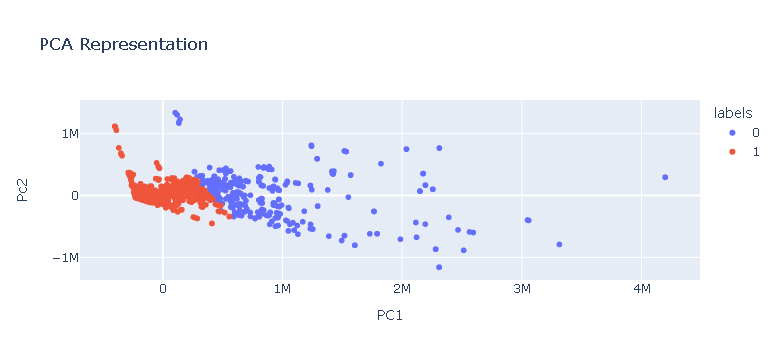

/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



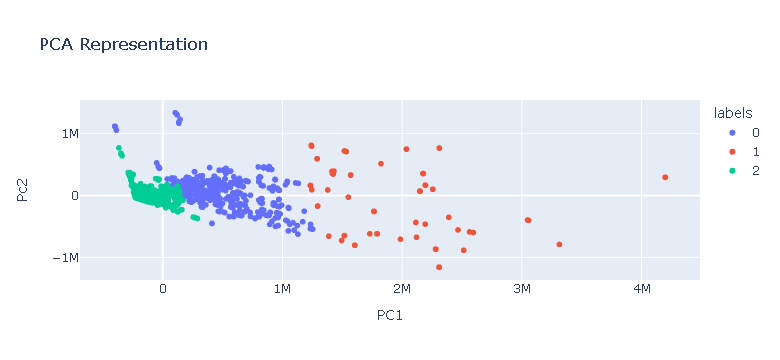

/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



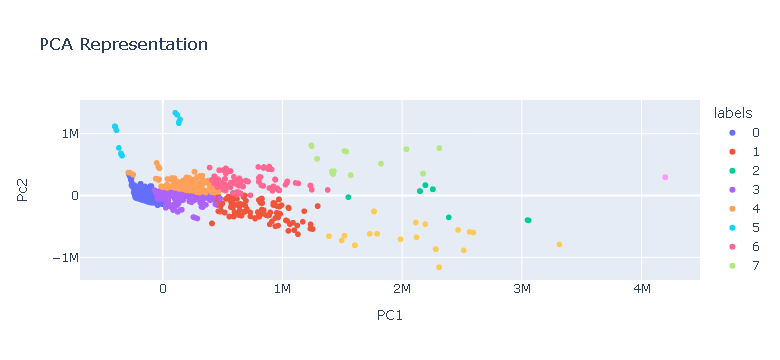

In [115]:
public_url = f"https://{os.environ['DW_CONTAINER_NAME']}-9000.{os.environ['DW_CONTAINER_HOST_NAME']}/"

app.run_server(host="0.0.0.0", port=9000, jupyter_server_url=public_url) 


---
Copyright 2023 WorldQuant University. This
content is licensed solely for personal use. Redistribution or
publication of this material is strictly prohibited.
